# Image registration: Deep learning approach, using Voxelmorph


## Introduction

Image registration is the process of aligning two images. For that purpose, one image is taken as a fixed image and the other one is moving image. The goal is to apply a transformation to moving image such that the transformed image(known as the registered image) has the same orientation and outer shape as the fixed image. The application of the process is vast. The major application of this problem is in medical imaging where two different types of images(like MRI and CT scan) of the same object need to be aligned properly for better understanding.

There are two types of algorithms in image registration. First is Rigid Image Registration(RIR) and the second is Deformation Image Registration (DIR). The process in which all transformations are affine that is the pixel to pixel relationship remains the same as before is known as RIR. This is a linear method and frequently used in the past. It is useful when the moving image has no deformity. The major drawback of this method is that it cannot be used when the moving image incurred some deformation. This happens quite often in medical images when there is a disease like a tumor which can grow or shrink with time. Deformation image registration(DIR) process is used in such cases.

DIR methods are employed when RIR cannot perform the desired task. They can be used to analysis and comparison of medical structures between the scans. Such analysis is used to assess and understand the evolution of brain anatomy over time for individuals with the disease. Deformable registration strategies often involve two steps: an initial affine transformation for global alignment, followed by a much slower deformable transformation with more degrees of freedom. We concentrate on the latter step, in which we compute a dense, nonlinear correspondence for all pixels.

## Voxel Morph

VoxelMorph, is a fast learning-based framework for deformable, pairwise medical image registration. 
Traditional registration methods optimize an objective function for each pair of images, which can be time-consuming for large datasets or rich deformation models. In contrast to this approach, and building on recent learning-based methods, voxelmorph formulates registration as a function that maps an input image pair to a deformation field that aligns these images. 

The idea then is to parameterize the function via a convolutional neural network (CNN), and optimize the parameters of the neural network on a set of images. 

Given a new pair of scans, VoxelMorph rapidly computes a deformation field by directly evaluating the function. In this work, we explore two different training strategies. 

In the first (unsupervised) setting, we train the model to maximize standard image matching objective functions that are based on the image intensities. 

In the second setting, we leverage auxiliary segmentations available in the training data. 


## Voxel Morph in action

We used/edited some functions from the free code available here https://github.com/voxelmorph/voxelmorph to implement and test voxelmorph in different scenarios.

Using the tensorflow version of the code:

- A) We trained a unet_core network from scratch with examples of pairs from MNIST database.
- B) We used pre-trained weights (on brain 2d images) to register a new pair of scans.
- C) We used the pre-trained network for some experiments and comments.

Using the pytorch version of the code:

- D) We adapted the available functions to perform 2D registration, initially written for 3d registration. We tried to build a small 2D scans database out of brats volumes, by writing a special datagenerator that yields batches on the fly at runtime, a batch is a set of batch_size pairs where each pair is composed of two slices, taken at same height, from two different volumes in brats. 

- E) We tried to implement segmentation loss

$\implies$ We tried to train an instance of voxelmorph network from scratch on that database. The results were not promising as shown below.

# USING TENSORFLOW

## A)  training a unet_core network from scratch on MNIST database

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#local, voxelmporph imports
from TensorFlow.voxelmorph.src import networks
from TensorFlow.voxelmorph.src.losses import Grad
from TensorFlow.voxelmorph.ext.neuron.neuron.layers import SpatialTransformer
from TensorFlow.voxelmorph.ext.neuron.neuron import plot

Using TensorFlow backend.


In [3]:
#third party imports
import keras
import numpy as np
from matplotlib.pyplot import imread
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def vxm_data_generator(x_data, batch_size=32):
    """
    generator that takes in data of size [N, H, W], and yields data for our vxm model
    Note that we need to provide numpy data for each input, and each output
    inputs:  moving_image [bs, H, W, 1], fixed_image [bs, H, W, 1]
    outputs: moved_image  [bs, H, W, 1], zeros [bs, H, W, 2]
    """
    # preliminary sizing
    vol_shape = x_data.shape[1:]  # extract data shape
    ndims = len(vol_shape)
    # prepare a zero array the size of the deformation. We'll explain this below.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    while True:
        # prepare inputs
        # inputs need to be of the size [batch_size, H, W, number_features]
        #   number_features at input is 1 for us
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        # outputs
        # we need to prepare the "true" moved image.
        # Of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]
        yield inputs, outputs

In [5]:
def get_model(vol_shape):
    ndims = len(vol_shape)
    nb_enc_features = [32, 32, 32, 32]
    nb_dec_features = [32, 32, 32, 32, 32, 16]
    unet = networks.unet_core(vol_shape, nb_enc_features, nb_dec_features)
    # inputs: moving image, fixed image
    moving_input_tensor = unet.inputs[0]
    fixed_input_tensor = unet.inputs[1]
    # output: displacement field, we transform the results into a flow field.
    disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)
    # warp the moving image using displacement filed -> we obtain moved image
    spatial_transformer = SpatialTransformer(name='spatial_transformer')
    moved_image_tensor = spatial_transformer([moving_input_tensor, disp_tensor])
    # setting the model: all together
    inputs = [moving_input_tensor, fixed_input_tensor]
    outputs = [moved_image_tensor, disp_tensor]
    vxm_model = keras.models.Model(inputs, outputs)
    # objective function
    losses = ['mse', Grad('l2').loss]
    lambda_param = 0.05
    loss_weights = [1, lambda_param]
    # compiling the model
    vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)
    return  vxm_model

In [6]:
#Loading data
from keras.datasets import mnist#Loading data
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()
x_train = x_train_load[y_train_load==5, ...]#we will extract only instances of the digit 5
y_train = y_train_load[y_train_load==5]
x_test = x_test_load[y_test_load==5, ...]
y_test = y_test_load[y_test_load==5]
nb_val = 1000 # keep 10,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]
# fix data: cnn's wish data to be normalized | the padding make the size 2^N -> helpful
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255
pad_amount = ((0, 0), (2,2), (2,2))
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')
#setting the model
vol_shape = x_train.shape[1:]
vx_model_scratch = get_model(vol_shape)
#the training phase
train_generator = vxm_data_generator(x_train)#batch training
nb_epochs = 10
steps_per_epoch = 100
hist = vx_model_scratch.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
 - 8s - loss: 0.0465 - spatial_transformer_loss: 0.0418 - disp_loss: 0.0950
Epoch 2/10
 - 7s - loss: 0.0245 - spatial_transformer_loss: 0.0192 - disp_loss: 0.1078
Epoch 3/10
 - 7s - loss: 0.0192 - spatial_transformer_loss: 0.0141 - disp_loss: 0.1022
Epoch 4/10
 - 7s - loss: 0.0165 - spatial_transformer_loss: 0.0117 - disp_loss: 0.0957
Epoch 5/10
 - 7s - loss: 0.0155 - spatial_transformer_loss: 0.0108 - disp_loss: 0.0937
Epoch 6/10
 - 7s - loss: 0.0145 - spatial_transformer_loss: 0.0100 - disp_loss: 0.0914
Epoch 7/10
 - 7s - loss: 0.0137 - spatial_transformer_loss: 0.0091 - disp_loss: 0.0907
Epoch 8/10
 - 7s - loss: 0.0130 - spatial_transformer_loss: 0.0086 - disp_loss: 0.0877
Epoch 9/10
 - 7s - loss: 0.0124 - spatial_transformer_loss: 0.0081 - disp_loss: 0.0854
Epoch 10/10
 - 7s - loss: 0.0124 - spatial_transformer_loss: 0.0081 - disp_loss: 0.0855


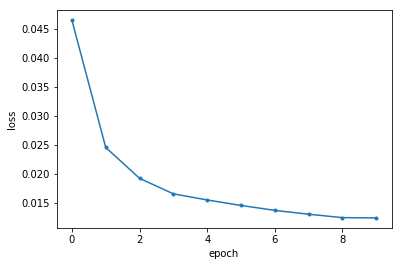

In [7]:
#loss evolution
plt.figure()
plt.plot(hist.epoch, hist.history['loss'], '.-')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
#registration/prediction, on an example from validation portion.
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)
val_pred = vx_model_scratch.predict(val_input)

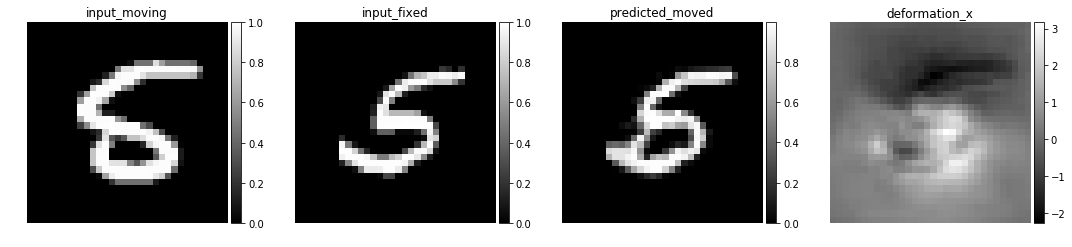

In [9]:
#visualization
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

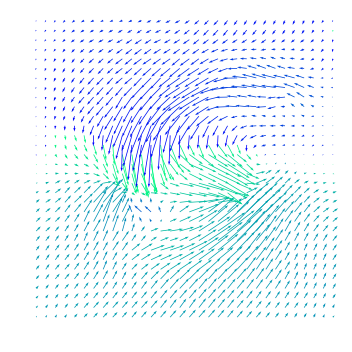

(<matplotlib.figure.Figure at 0x7f86fc13f6d8>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f86f025c080>])

In [10]:
#the resultingg displacement vector
plot.flow([val_pred[1].squeeze()], width=5)

## B) using pre-trained weights (on brain 2d images) to register a new pair of scans.

In [11]:
#Loading images: braind_2d pair
new_fixed = rgb2gray(resize(imread('pairs/paire1_1.png'), (256, 256)))#Loading new example's fixed component
new_moving = rgb2gray(resize(imread('pairs/paire1_2.png'), (256, 256)))#Loading new example's moving component

In [19]:
#setting inputs and the model; loading weights
x_val = np.asarray([new_moving, new_fixed])
vol_shape = new_fixed.shape
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)
vxm_model_pretrained = get_model(vol_shape)#setting the network
vxm_model_pretrained.load_weights('weights/brain_2d_shortrun.h5')#Loading pre-trained weights, found on kaggle tutorial

In [20]:
#prediction
outs = vxm_model_pretrained.predict(val_input)#prediction

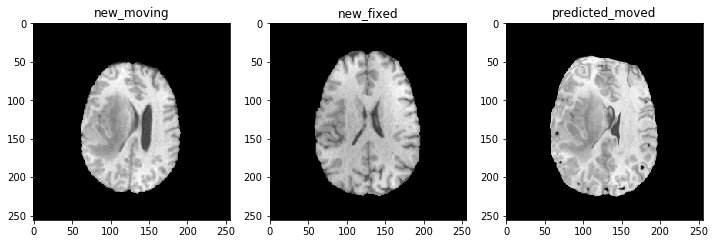

In [21]:
plt.figure(figsize=(12, 7))
plt.subplot(131)
plt.imshow(new_moving, cmap='gray')
plt.title("new_moving")
plt.subplot(132)
plt.imshow(new_fixed, cmap='gray')
plt.title("new_fixed")
plt.subplot(133)
plt.imshow(outs[0].reshape((256,256)), cmap='gray')
plt.title("predicted_moved")

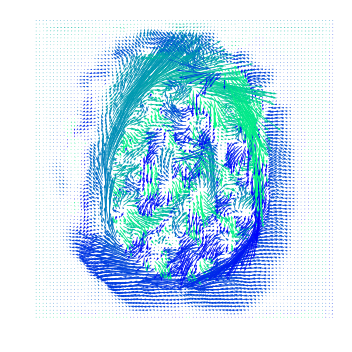

(<matplotlib.figure.Figure at 0x7f86b4400f60>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7f86b4468ba8>])

In [22]:
#displacement field
plot.flow([outs[1].squeeze()[::3,::3]], width=5)

## C) Using the pre-trained network for some experiments and comments.


First observation :As we an see the prediction time while being slower than in article ,it still surpass the other state of the art methods mentioned in the article such as ANT and NiftyReg

In this case we are using two slices from brain scans containing different type of tumours Low-grade glioma LGG,we can see that the registered image have a form very similar to the target.However since the two slice got different color intensity, the matching in term of smaller detail is a lot less accurate but still make a lot of sense.

Using two slices High grade glioma HGG,we can find similar result to last experiment . We can note similar results.

In this example we take two slice from different position in same brain scan, we can see that the algorithm is unable to find a good enough transformation to reach the target.

An interresting observation to note is that even using same image as both target and moving, we still obtain a small field.Since the method is based on neural networks , so we dont have a perfect solution even for most trivial case .


Surprisingly, we can see results that are not very bad between HGG and LGG slices.While a lot of details are inherently differents, we see some matching for the dark areas.



if we try use horizontal slices of brain scan(our weights are trained on vertical slices), we can see interresting results. In term of format even if imperfect , the registered image is close in form to the target than the original . However , in term of details and grayscale intensity there the results seams random and doesn't carry any kind of precision.




# USING PYTORCH 


In [10]:
import os
import glob
import random
import matplotlib.pyplot as plt

# external imports
import numpy as np
import torch
from torch.optim import Adam
from torch.utils import data
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import skimage.io as io

# internal imports
from Pytorch.model import cvpr2018_net
import Pytorch.datagenerators
import Pytorch.losses
from Pytorch.utils import unstack_seg

use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if use_gpu else "cpu")

In [2]:
HGG_folders = list(set([x for x in os.listdir('HGG')]))
LGG_folders = list(set([x for x in os.listdir('LGG')]))
HGG_files = list(map(lambda folder_name: 'HGG/' + folder_name + '/' + folder_name + '_t1.nii.gz', HGG_folders))
LGG_files = list(map(lambda folder_name: 'LGG/' + folder_name + '/' + folder_name + '_t1.nii.gz', LGG_folders))

### Train/test split

Here, we used the available datagenerators and adapted them to extract 2d pairs of slices from patients 3d scans.
For instance, datagenerators.example_gen yields batches of given size at runtime, each batch is composed of N pairs, each pair is a tuple of :
* a moving image (1st 2D slice taken at height X from a 3D volume)
* a fixed image (2nd 2D slice taken at same height X from another 3D volume)

In [3]:
all_files = HGG_files + LGG_files

In [4]:
training_files, validation_files =  train_test_split(all_files)

In [5]:
batch_size = 4
training_data = datagenerators.example_gen(training_files, batch_size=batch_size,return_segs=True)
validation_data = datagenerators.example_gen(validation_files, batch_size=batch_size)

### One epoch of training

In [7]:
lr = 1e-4
nf_enc = [16, 32, 32, 32]
nf_dec = [32, 32, 32, 32, 8, 8]
model = cvpr2018_net((240, 240), nf_enc, nf_dec)
model.to(device)
opt = Adam(model.parameters(), lr=lr)
reg_param = 1.0 #regularization Coeff
seg_param = 0.1 #segmenatation Loss Coeff

train_loss = 0
train_dice = 0
train_seg=0

nbr_pairs = 0
for i in range(int(len(training_files)/(2*batch_size))):
    
    moving_batch,moving_batch_seg= next(training_data)
    fixed_batch,fixed_batch_seg= next(training_data)
    

    input_moving = torch.from_numpy(moving_batch).to(device).float()
    input_moving = input_moving.permute(0, 3, 1, 2)
    
    input_fixed  = torch.from_numpy(fixed_batch).to(device).float()
    input_fixed  = input_fixed.permute(0, 3, 1, 2)

    
    input_moving_seg = torch.from_numpy(moving_batch_seg).to(device).float()
    input_moving_seg = input_moving_seg.permute(0, 3, 1, 2) 
    input_moving_seg = unstack_seg(input_moving_seg,batch_size)
    input_moving_seg = torch.from_numpy(input_moving_seg).to(device).float()

    input_fixed_seg  = torch.from_numpy(fixed_batch_seg).to(device).float()
    input_fixed_seg = input_fixed_seg.permute(0, 3, 1, 2)
    input_fixed_seg = unstack_seg(input_fixed_seg,batch_size)
    input_fixed_seg  = torch.from_numpy(input_fixed_seg).to(device).float()

        
    warp, flow = model(input_moving, input_fixed)

    recon_loss = losses.ncc_loss(warp, input_fixed) 
    
    grad_loss = losses.gradient_loss(flow)
    
    seg_loss=losses.segmentationLoss(input_fixed_seg, input_moving_seg,model)


    #We Added The segementation loss , and we took into concediration the structure of brain 

    loss = recon_loss + reg_param * grad_loss + seg_param * seg_loss
    
    train_loss += loss.data

    train_dice += losses.dice_score(input_fixed,  warp).data
    
    train_seg+=losses.segmentationLoss(input_fixed_seg, input_moving_seg,model)

    nbr_pairs += batch_size
    
    print("With {0} examples, average loss is {1}, dice score is {2} , ".format(nbr_pairs,
                                                                       train_loss*batch_size/len(training_files),
                                                                       train_dice*batch_size/len(training_files)))
   
    
    print()
    opt.zero_grad()
    loss.backward()
    opt.step()

/ldaphome/ancibi/.local/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


With 4 examples, average loss is -0.0012036801781505346, dice is 6.523696422576904

With 8 examples, average loss is -0.0024992323014885187, dice is 13.0648775100708

With 12 examples, average loss is -0.0028892564587295055, dice is 20.39218521118164

With 16 examples, average loss is -0.00224517984315753, dice is 31.751123428344727

With 20 examples, average loss is -0.0029776813462376595, dice is 40.112308502197266

With 24 examples, average loss is -0.003825101535767317, dice is 47.37253189086914

With 28 examples, average loss is -0.005960250739008188, dice is 53.13917541503906

With 32 examples, average loss is 0.08091537654399872, dice is 59.79741668701172

With 36 examples, average loss is 0.08016949892044067, dice is 66.8821029663086

With 40 examples, average loss is 0.0781698152422905, dice is 73.69412231445312

With 44 examples, average loss is 0.07728245109319687, dice is 82.09380340576172

With 48 examples, average loss is 0.0762520581483841, dice is 89.86882781982422

Wit

### Prediction, registering a new pair

In [8]:
new_moving = next(validation_data)[0]
input_moving = torch.from_numpy(new_moving).to(device).float()
input_moving = input_moving.permute(0, 3, 1, 2)

new_fixed = next(validation_data)[0]
input_fixed  = torch.from_numpy(new_fixed).to(device).float()
input_fixed  = input_fixed.permute(0, 3, 1, 2)

In [11]:
warp, flow = model(input_moving, input_fixed) #warp is the deformed=moved, flow is the defromation field

/ldaphome/ancibi/.local/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


### We visualize the flow

In [12]:
flow_array = flow.detach().numpy()
flow_array = flow_array.squeeze()
displ_x = flow_array[0,0,:,:]
displ_y = flow_array[0,1,:,:]

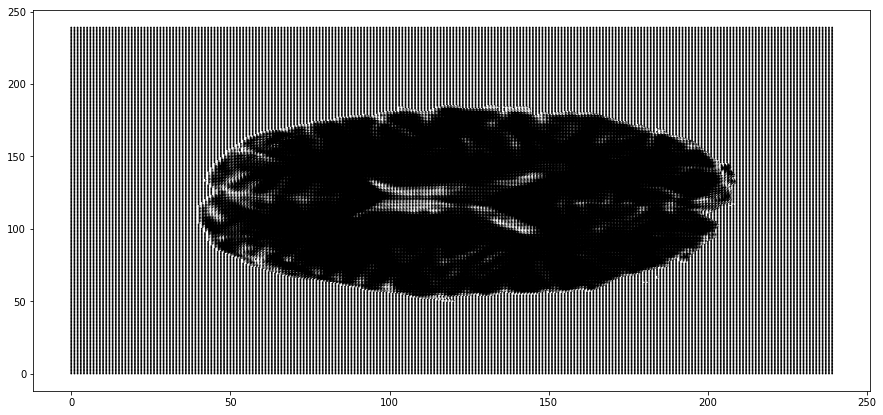

In [13]:
plt.figure(figsize=(15,7))
plt.quiver(displ_x, displ_y)
plt.show()

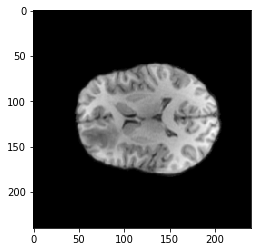

In [14]:
registered = warp.detach().numpy().squeeze()
plt.imshow(registered[1,:,:], cmap='gray')

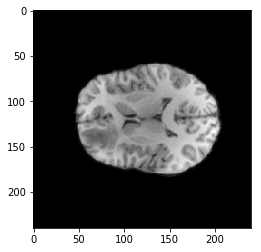

In [15]:
plt.imshow(new_moving[1,:,:].squeeze(), cmap='gray')

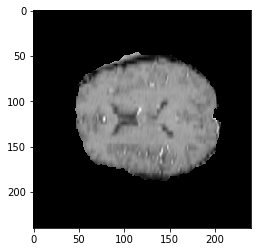

In [16]:
plt.imshow(new_fixed[1,:,:].squeeze(), cmap='gray')